# Projet de dimensionnement de stockage embarqué dans un tramway

Baptiste Braun-Delvoye  
Dan Calamia  
Judicaël Corpet

### Mise en place du modèle du système

#### 1) Système simulé sans batterie

Initialisation des données

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#%% Création et conversion des données

VLAC = 750 #Volts
VSST = 790 #Volts
RSST = 33*1e-3 #mOhm
RHOLAC = 131e-6 # Ohm/m
RHORAIL = 18e-6 # Ohm/m

Times = []
X = []
V = [] #km/h-1 vitesse du train à déterminer avec le fichier marche_train.txt
Acc = [] #km/h-2 accélération du train à déterminer avec le fichier marche_train.txt
RLAC1 = [] # Résistance de la LAC entre la sous-station 1 et le train (valeurs dépendante de x)
RLAC2 = [] # Résistance de la LAC entre la sous-station 2 et le train (valeurs dépendante de x)
Rrail1 = [] # Résistance du rail entre la sous-station 1 et le train (valeurs dépendante de x)
Rrail2 = [] # Résistance du rail entre la sous-station 2 et le train (valeurs dépendante de x)
R1 = [] # Résistance équivalente pour la partie supérieure du schéma de Thévenin, traversée par le courant I1 (dépend de x)
R2 = [] # Résistance équivalente pour la partie inférieure du schéma de Thévenin, traversée par le courant I2 (dépend de x)
Req = [] # Résistance équivalente totale du schéma de Thévenin (dépend de x)
PLAC = [] #Puissance de la LAC (dépend de x)
Vtrain = [] #Tension du train à tout instant (dépend de x)
Itrain = [] #Intensité aux bornes du train à tout moment (dépend de x)
I1 = [] #Intensité de la partie supérieure du schéma de Thévenin
I2 = [] #Intensité de la partie inférieure du schéma de Thévenin

alpha = 0 # angle de la pente du chemin
M = 70*1e3 #tonnes masse du train
A0 = 780 #N constante forces
A1 = 6.4*1e-3 #N/tonnes constante accélération
B0 = 0.0 # constante nulle ?
B1 = 0.14*3600/(1e3*1e3) #N/tonnes/(km•h-1) constante
C0 = 0.3634*(3600**2)/(1e3*1e6) #N/tonnes/(km•h-1)^2 constante inverse vitesse
C1 = 0.0

Ajout des données du fichier "marche_train.txt" :

In [21]:
FICHIER = "marche_train.txt" # nom du fichier dans le dossier

Times, X = get_T_X(FICHIER)

Définition de fonctions qui nous aiderons à aller plus vite dans le code au fur et à mesure du projet (Ces fonctions sont enregistrées normalement dans un fichier auquel nous faisons appel)

In [13]:
def readlist(file) : return list(map(float,file.readline().split()))
#Cette fonction permet simplement de lire une ligne d'un fichier et d'enregister chaque valeur
# séparé par un espace comme variable

def trace(x, y, xlabel, ylabel, titre, xlim=0, ylim=0, save=False, nom=None):
    fig, ax = plt.subplots(1, 1)

    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.suptitle(titre)

    if xlim != 0 and isinstance(xlim, list):
        ax.set_xlim(xlim)
    if ylim != 0 and isinstance(ylim, list):
        ax.set_ylim(ylim)

    plt.show()

    if save == True and nom != None:
        fig.savefig(nom, dpi=900)

def get_T_X(filename):
    Times = []
    X = []
    
    file = open(filename, 'r')
    readedlist = readlist(file)
    
    while readedlist:
        Time, Position = readedlist
        Times.append(Time)
        X.append(Position)
        readedlist = readlist(file)
    return np.array(Times), np.array(X)

def get_V(Times, X):
    taille = len(X)
    
    V = []
    
    V.append(0) #TODO revoir différence fini ordre supérieure
    for i in range(taille - 1):
        if i<2 or i>taille-3:
            v = (X[i+1]-X[i])/(Times[i+1]-Times[i])
        else:
            v = (X[i-2] - 8*X[i-1] + 8*X[i+1] - X[i+2])/(12*(Times[i+1]-Times[i]))
        V.append(v)

    V = np.array(V) 
    return V

def get_Acc(Times,V):
    taille = len(V)
    
    Acc = []
    
    Acc.append(0)
    for i in range(taille-1):
        if i<2 or i>taille-3:
            a = (V[i+1]-V[i])/(Times[i+1]-Times[i])
        else:
            a = (V[i-2] - 8*V[i-1] + 8*V[i+1] - V[i+2])/(12*(Times[i+1]-Times[i]))
        Acc.append(a)

    Acc = np.array(Acc)
    return Acc

# méthode des trapèze pour résoudre l'integral de P batterie de t0 à t
def methode_trapeze(fonction_a_integre):
    
    a=0
    b=10
    n=100
    somme=0
    h= (b-a)/n
    for i in range(1,n):
        aire=(fonction_a_integre(a)+fonction_a_integre(a+h))*h/2
        somme+=aire
        a+=h
        i+=1
    return somme

Calcul de la vitesse, de l'accélération, des forces et de la puissance :

In [25]:
V = get_V(Times, X)

Acc = get_Acc(Times, V)

FR = (A0 + A1*M) + (B0 + B1*M)*V + (C0 + C1*M)*V**2 # Force resistive

Fm = M*Acc + M*9.81*np.sin(alpha) + FR # Force mécanique - ici alpha = 0

Pm = Fm*V

Tracé des courbes de position, de vitesse et de puissance :

Text(0.5, 0, 't [s]')

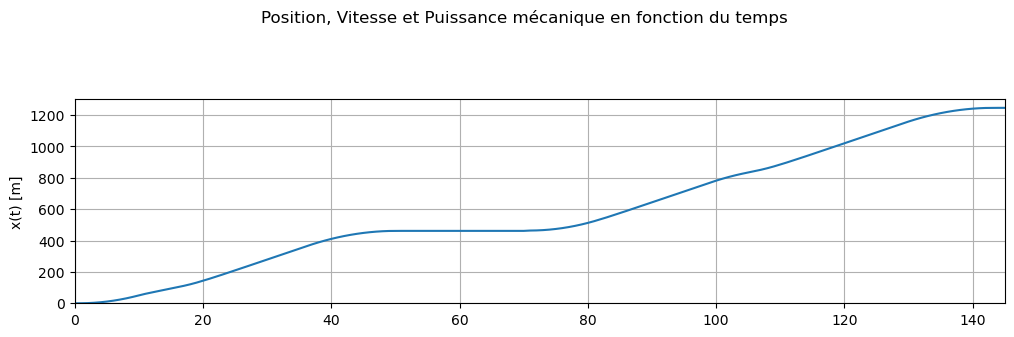

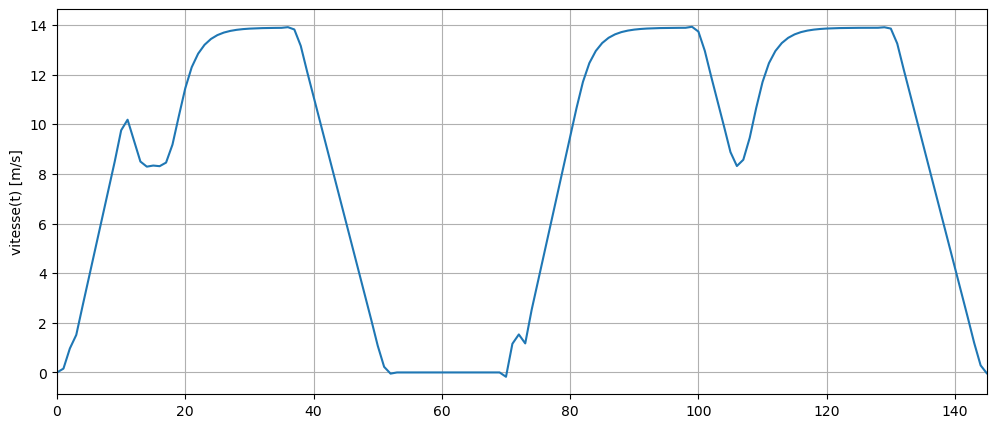

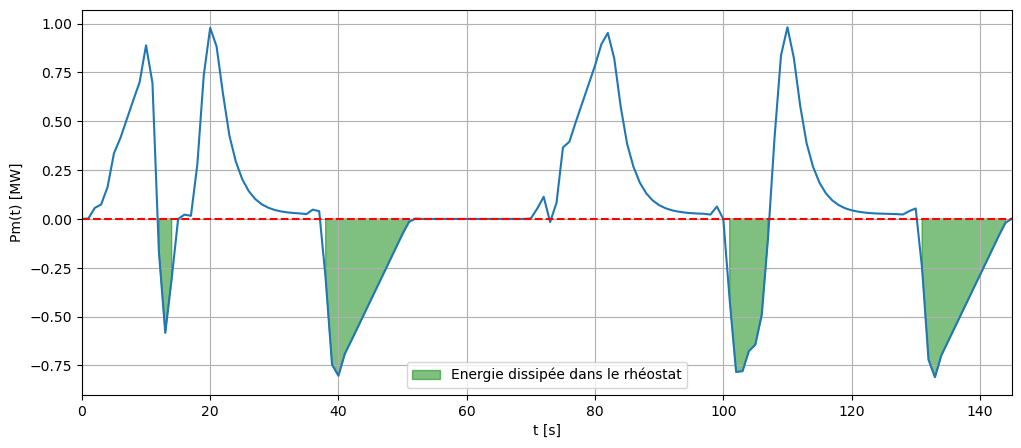

In [216]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, X)
plt.grid()
plt.xlim([0,145])
plt.ylim([0,1300])
plt.ylabel("x(t) [m]")
plt.suptitle("Position, Vitesse et Puissance mécanique en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, V)
plt.grid()
plt.xlim([0,145])
plt.ylabel("vitesse(t) [m/s]")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Pm*1e-6)
plt.plot(Times, np.zeros(len(Times)), '--', color='red')
plt.grid()
plt.xlim([0,145])
plt.fill_between(Times, Pm*1e-6, 0, where = (Pm*1e-6<=0), color = 'green', alpha = 0.5, label = 'Energie dissipée dans le rhéostat')
plt.legend()
plt.ylabel("Pm(t) [MW]")
plt.xlabel("t [s]")

**Commentaire :**  
On remarque que la puissance mécanique est négative lors des phases de freinage.
Cette puissance est perdue car elle ne peut pas être réinjectee dans le circuit.
On déduit que ces phases vont être à exploiter pour recharger une batterie.

Partie électronique 

Calcul de RLAC1, RLAC2, Rrail1, Rrail2 en fonction de x

In [31]:
RLAC1 = RHOLAC*X

RLAC2 = (X[-1] - X)*RHOLAC

Rrail1 = RHORAIL*X

Rrail2 = (X[-1] - X)*RHORAIL


Après simplification du schéma par le théorème de Thévenin calcul de R1, R2 et Req :

In [34]:
R1 = RSST + RLAC1 + Rrail1

R2 = RSST + RLAC2 + Rrail2

Req = (R1*R2)/(R1+R2)


Tracé des courbes des résistances en fonction du temps :

Text(0.5, 0, 't [s]')

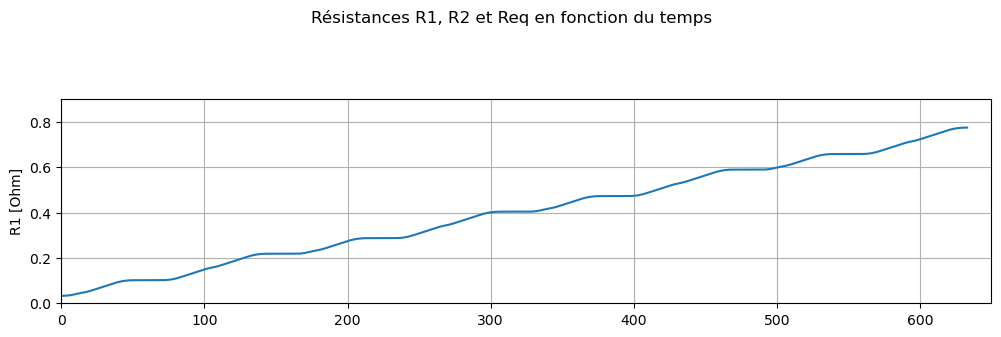

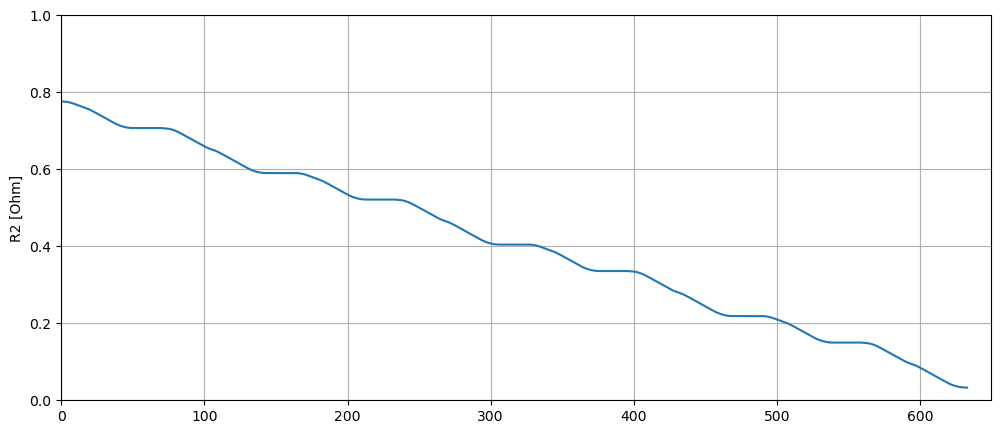

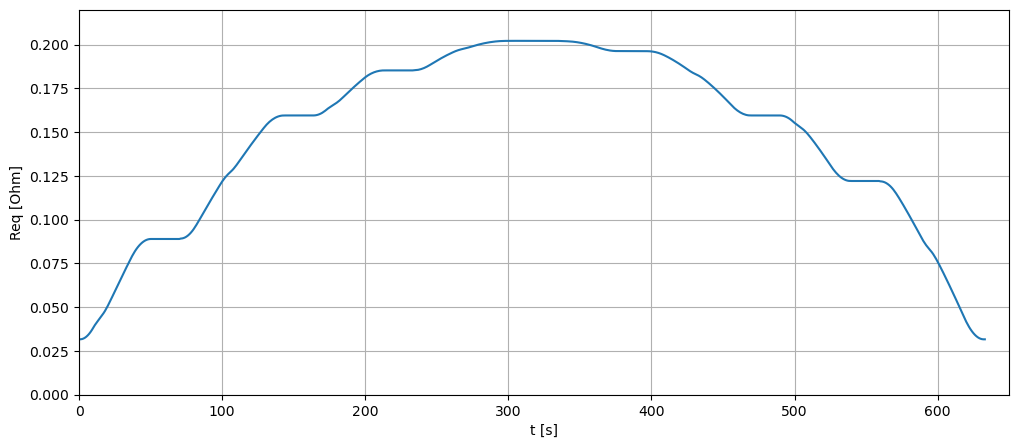

In [207]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, R1)
plt.grid()
plt.xlim([0,650])
plt.ylim([0,0.9])
plt.ylabel("R1 [Ohm]")
plt.suptitle("Résistances R1, R2 et Req en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, R2)
plt.grid()
plt.xlim([0,650])
plt.ylim([0,1])
plt.ylabel("R2 [Ohm]")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Req)
plt.grid()
plt.xlim([0,650])
plt.ylim([0, 0.22])
plt.ylabel("Req [Ohm]")
plt.xlabel("t [s]")

**Commentaire :**  
On remarque que, plus le train est éloigné de la sous-station 1, plus la résistance 1 est grande.
Il en est de même pour R2 par rapport à la distance de la sous-station 2.

La courbe de Req est donc logiquement une parabole avec un pic entre les 2 sous-stations.

Calcul de PLAC :

In [37]:
#PLAC = Pm

Calcul de Vtrain :

In [40]:
for i in range(len(X)):
    if Pm[i]<0:
        racine = VSST**2 - 4*Req[i]*(Pm[i]*0.8)
    else:
        racine = VSST**2 - 4*Req[i]*(Pm[i]/0.8)
    if racine < 0:
        racine = 0
    vtrain = (VSST + np.sqrt(racine))/2
    Vtrain.append(vtrain)

**Commentaire :**  
Si la puissance mécanique du train est négative, on la multiplie par le rendement (0.8), ce qui signifie une perte de puissance mécanique notamment lors des phases de freinage, et inversement lorsque la puissance mécanique est positive.

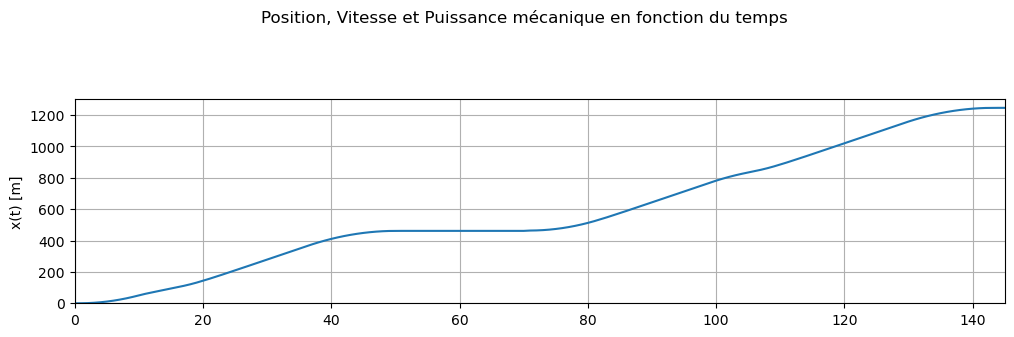

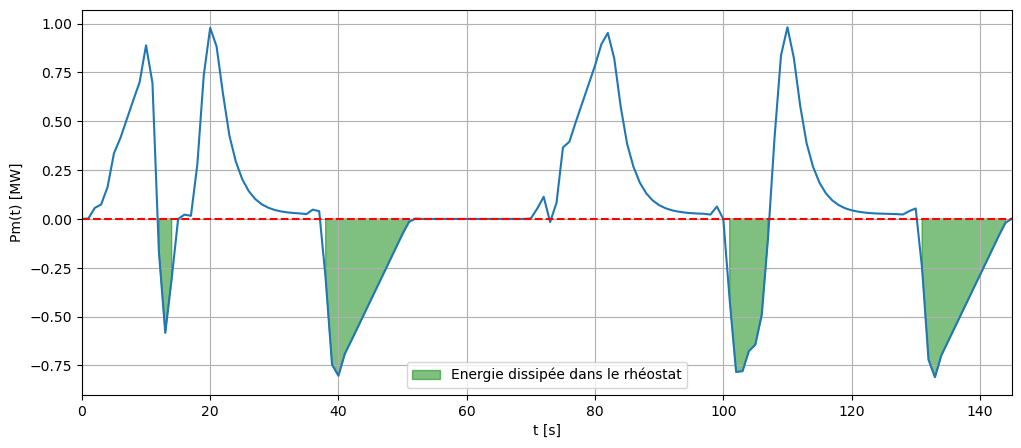

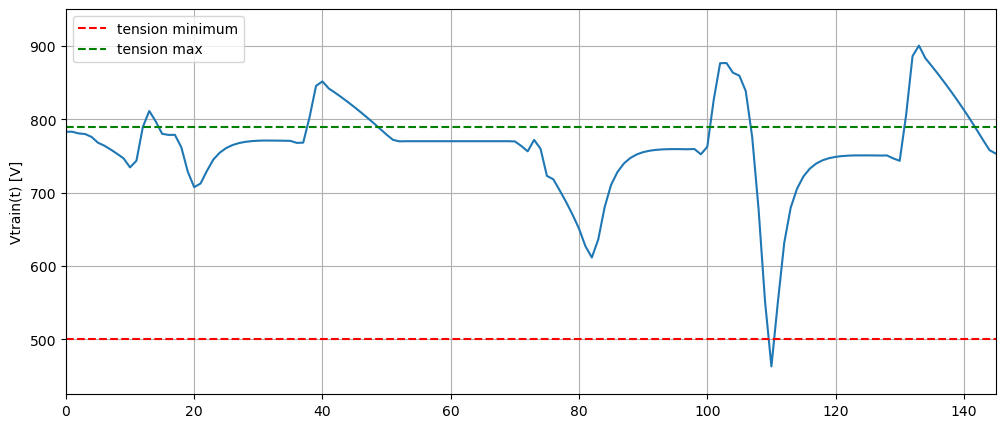

In [238]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, X)
plt.grid()
plt.xlim([0,145])
plt.ylim([0,1300])
plt.ylabel("x(t) [m]")
plt.suptitle("Position, Vitesse et Puissance mécanique en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, Pm*1e-6)
plt.plot(Times, np.zeros(len(Times)), '--', color='red')
plt.grid()
plt.xlim([0,145])
plt.fill_between(Times, Pm*1e-6, 0, where = (Pm*1e-6<=0), color = 'green', alpha = 0.5, label = 'Energie dissipée dans le rhéostat')
plt.legend()
plt.ylabel("Pm(t) [MW]")
plt.xlabel("t [s]")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Vtrain)
plt.grid()
plt.xlim([0,145])
plt.ylim([425, 950])
x = [0,145]
y = [500, 500]
y1 = [790, 790]
plt.plot(x, y, '--r', label = 'tension minimum')
plt.plot(x, y1, '--g', label = 'tension max')
plt.ylabel("Vtrain(t) [V]")
plt.legend()

Calcul de Itrain :

In [43]:
Itrain = VSST - Vtrain/Req

**Commentaire :**  
Calcul de I1 :
On sait d'après la loi des mailles que V1 - V2 = 0, donc V1 = V2, donc R1 * I1 = R2 * I2, donc I2 = (R1 * I1)/R2
D'après la loi des noeuds, I1 + I2 = Itrain, donc en remplaçant I2 par son expression en fonction de I1 on obtient :
I1 + (R1 * I1)/R2 = Itrain, donc I1(R2 + R1)/R2 = Itrain, donc I1 = (R2 * Itrain)/(R1 + R2)

In [46]:
I1 = (R2*Itrain)/(R1+R2)

Calcul de I2 :

In [49]:
I2 = (R1*I1)/R2

Text(0.5, 0, 't [s]')

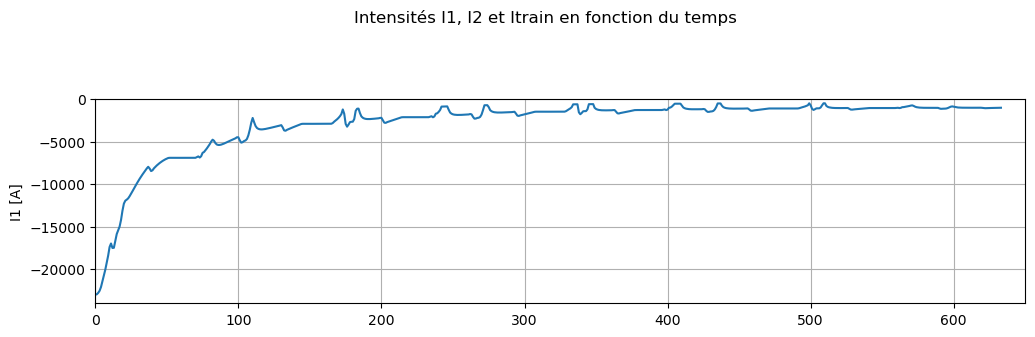

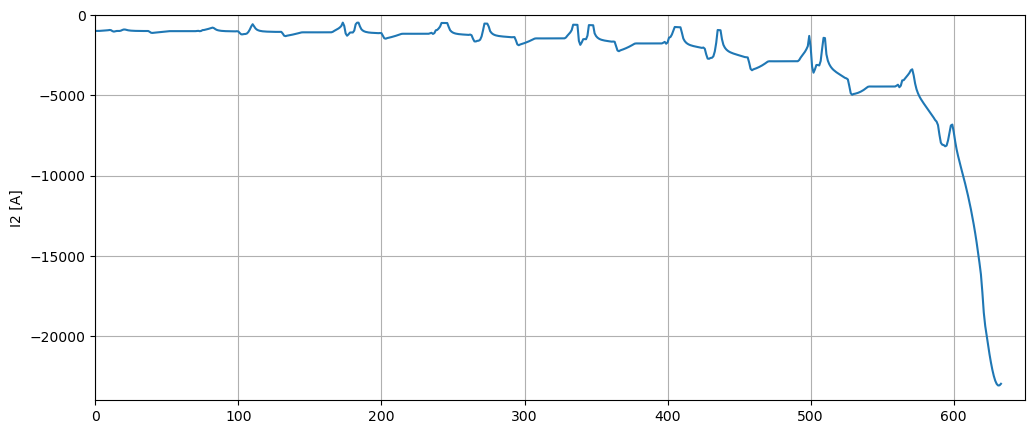

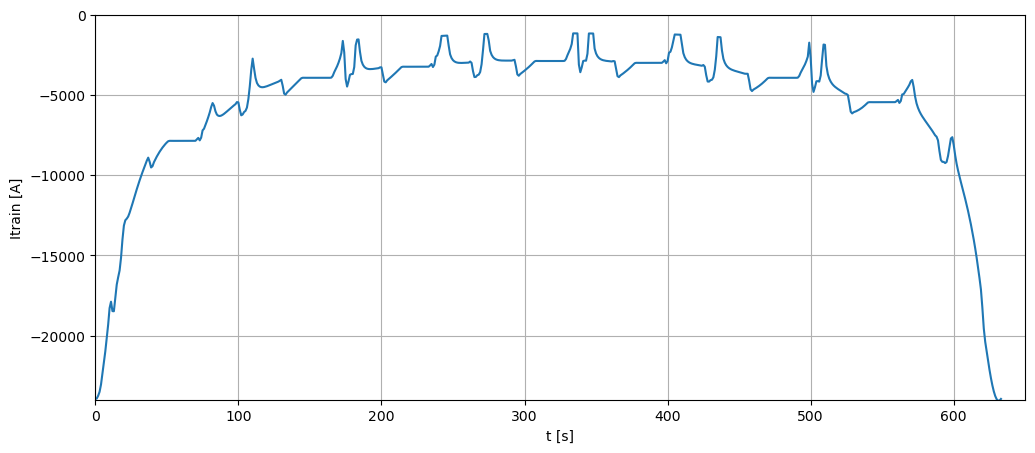

In [211]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, I1)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.ylabel("I1 [A]")
plt.suptitle("Intensités I1, I2 et Itrain en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, I2)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.ylabel("I2 [A]")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Itrain)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.ylabel("Itrain [A]")
plt.xlabel("t [s]")

Calcul de la puissance de chaque sous-station : Psst = Vsst*Isst = Vsst**2 / Rsst

In [52]:
PSST = VSST**2 / RSST

### Commentaires